## Import Modules

In [1]:
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from datetime import datetime
from scipy.optimize import minimize

## Define Functions

In [148]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=5):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

In [141]:
from typing import Iterable 
#from collections imtmp Iterable                            

def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

## Import Data

In [3]:
df_price = pd.read_excel("Price.xlsx", index_col=0) 
df_price.index = df_price.index.to_series().dt.to_period('M')
df_price

,Mnemonic,Close
Date,,
2019-12,4SI:XJSE:EQU,32.0
2019-11,4SI:XJSE:EQU,20.0
2019-10,4SI:XJSE:EQU,20.0
2019-09,4SI:XJSE:EQU,20.0
2019-08,4SI:XJSE:EQU,18.0
...,...,...
2009-05,ZED:XJSE:EQU,144.0
2009-04,ZED:XJSE:EQU,148.0
2009-03,ZED:XJSE:EQU,140.0


In [4]:
df_size = pd.read_excel("Market Capitalizations.xlsx", usecols=[0,2,3], index_col=1)
df_size.index = df_size.index.to_series().dt.to_period('M')
df_size

,Mnemonic,Market Cap
Date,,
2019-12,4SI:XJSE:EQU,253217582.0
2019-11,4SI:XJSE:EQU,158260989.0
2019-10,4SI:XJSE:EQU,158260989.0
2019-09,4SI:XJSE:EQU,158260989.0
2019-08,4SI:XJSE:EQU,142434890.0
...,...,...
2009-05,ZED:XJSE:EQU,880279665.0
2009-04,ZED:XJSE:EQU,904687478.0
2009-03,ZED:XJSE:EQU,855785452.0


In [5]:
df_MR = pd.read_excel("J203T Price.xlsx", usecols=[0,1], index_col=0)
df_MR

,J203T
Dates,
2000-01-04,694.664
2000-01-05,687.378
2000-01-06,688.400
2000-01-07,705.859
2000-01-10,729.218
...,...
2020-02-24,8332.211
2020-02-25,8321.271
2020-02-26,8357.358


In [6]:
df_RF = pd.read_excel("91days T-Bill rate.xlsx", index_col=0)
df_RF


,Value
Date,
2000-01-05,10.71
2000-01-06,10.71
2000-01-07,10.56
2000-01-10,10.56
2000-01-11,10.56
...,...
2019-12-25,7.19
2019-12-26,7.19
2019-12-27,7.16


## Sorting Data

Reform price data frame

In [7]:
tmp = pd.DataFrame()
labels = []
n = int((2019-2009+1)*12)

for i in range(int(len(df_price)/n)): 
    price = pd.DataFrame(df_price.iloc[n*i:n*(i+1),1])
    name = df_price.iloc[range(1,len(df_price),n)[i],0]
    tmp = pd.concat([tmp,price], axis=1)
    labels.append(name)
    tmp.columns = [labels]


In [8]:
df_price = tmp
# reorder the date of price data
df_price = df_price.sort_index(ascending=True)
df_price.columns = df_price.columns.get_level_values(0).values
df_price

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,9300.0,NaN,NaN,4000.0,2290.0,NaN,370.0,5099.0,NaN,...,905.0,1750.0,116.0,64.0,9718.0,1345.0,32.0,NaN,1600.0,155.0
2009-02,NaN,8900.0,NaN,NaN,3826.0,2050.0,NaN,350.0,4399.0,NaN,...,825.0,850.0,108.0,40.0,8500.0,1190.0,25.0,NaN,1150.0,146.0
2009-03,NaN,9620.0,NaN,NaN,3600.0,1700.0,NaN,371.0,4400.0,NaN,...,919.0,1500.0,120.0,54.0,8509.0,1140.0,18.0,NaN,540.0,140.0
2009-04,NaN,9845.0,NaN,NaN,4200.0,2100.0,NaN,400.0,4875.0,NaN,...,930.0,750.0,134.0,70.0,10001.0,1200.0,18.0,NaN,540.0,148.0
2009-05,NaN,10155.0,NaN,NaN,4200.0,2300.0,NaN,415.0,4600.0,NaN,...,960.0,600.0,170.0,55.0,10355.0,1250.0,22.0,NaN,460.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,18.0,15369.0,295.0,725.0,5775.0,2000.0,45.0,1109.0,9099.0,NaN,...,1872.0,255.0,40.0,3.0,10018.0,5518.0,140.0,1800.0,170.0,470.0
2019-09,20.0,15287.0,174.0,725.0,5675.0,2055.0,38.0,1250.0,9596.0,NaN,...,1900.0,255.0,52.0,3.0,14290.0,5508.0,160.0,1840.0,160.0,470.0
2019-10,20.0,15488.0,198.0,600.0,5624.0,1370.0,42.0,1125.0,9765.0,NaN,...,1934.0,250.0,55.0,3.0,14118.0,5749.0,160.0,1865.0,160.0,490.0


Reform size data frame

In [9]:
tmp = pd.DataFrame()

for i in range(int(len(df_size)/n)): 
    size = pd.DataFrame(df_size.iloc[n*i:n*(i+1),1])
    tmp = pd.concat([tmp,size], axis=1)
tmp.columns = flatten([labels])

In [10]:
df_size = tmp
# reorder the date of size data
df_size = df_size.sort_index(ascending=True)
df_size

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-01,NaN,6.326588e+10,NaN,NaN,6.916287e+09,1.238633e+09,NaN,1.456560e+09,6.060008e+09,NaN,...,2.674735e+09,431987500.0,679168221.0,117095434.0,6.413880e+09,1.074192e+10,76800000.0,NaN,1.253921e+09,9.474768e+08
2009-02,NaN,6.054477e+10,NaN,NaN,6.615428e+09,1.111497e+09,NaN,1.377827e+09,5.228079e+09,NaN,...,2.438295e+09,209822500.0,632329033.0,73184646.0,5.610000e+09,9.504005e+09,60000000.0,NaN,9.012558e+08,8.924620e+08
2009-03,NaN,6.545181e+10,NaN,NaN,6.224658e+09,9.217295e+08,NaN,1.460497e+09,5.229267e+09,NaN,...,2.716113e+09,370275000.0,702587815.0,98799273.0,5.615940e+09,9.112693e+09,43200000.0,NaN,4.231984e+08,8.557855e+08
2009-04,NaN,6.698264e+10,NaN,NaN,7.262101e+09,1.138607e+09,NaN,1.574660e+09,5.793791e+09,NaN,...,2.748623e+09,185137500.0,784556393.0,128073131.0,6.600660e+09,9.592308e+09,43200000.0,NaN,4.231984e+08,9.046875e+08
2009-05,NaN,6.909180e+10,NaN,NaN,7.262101e+09,1.247046e+09,NaN,1.633709e+09,5.466961e+09,NaN,...,2.837288e+09,148110000.0,995332738.0,100903889.0,6.834300e+09,9.991988e+09,52800000.0,NaN,3.605023e+08,8.802797e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,142434890.0,1.302908e+11,2.945648e+09,2.863460e+09,1.015007e+10,2.199094e+09,129594794.0,6.061937e+09,1.108523e+10,NaN,...,1.790056e+10,410947583.0,651130823.0,8291796.0,5.999832e+09,5.785436e+10,341223880.0,9.524873e+08,5.631090e+08,8.061342e+09
2019-09,158260989.0,1.295956e+11,1.737433e+09,2.863460e+09,9.974315e+09,2.259569e+09,109435604.0,6.832661e+09,1.169072e+10,NaN,...,1.816831e+10,410947583.0,846470070.0,8291796.0,8.558354e+09,5.774957e+10,389970148.0,9.736537e+08,5.299850e+08,8.061342e+09
2019-10,158260989.0,1.312996e+11,1.977079e+09,2.369760e+09,9.884678e+09,1.506379e+09,120955141.0,6.149395e+09,1.189661e+10,NaN,...,1.849342e+10,402889787.0,895304881.0,8291796.0,8.455343e+09,6.027737e+10,389970148.0,9.868827e+08,5.299850e+08,8.404378e+09


Calculate stock returns

In [11]:
# np.log(1 + df_price.pct_change()) #or below
df_SR = np.log(df_price/df_price.shift(1)) # formula = ln(Pt/Pt-1)
df_SR = df_SR.iloc[1:,:]
df_SR.replace([np.inf, -np.inf], np.nan, inplace=True) # replace the inf number to NA as ln(0) will return inf
# np.isinf(df_SR).sum().sum() # test whether infs are replaced 
df_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,-0.043963,NaN,NaN,-0.044474,-0.110712,NaN,-0.055570,-0.147667,NaN,...,-0.092552,-0.722135,-0.071459,-0.470004,-0.133914,-0.122441,-0.246860,NaN,-0.330242,-0.059818
2009-03,NaN,0.077793,NaN,NaN,-0.060886,-0.187212,NaN,0.058269,0.000227,NaN,...,0.107903,0.567984,0.105361,0.300105,0.001058,-0.042925,-0.328504,NaN,-0.755948,-0.041964
2009-04,NaN,0.023119,NaN,NaN,0.154151,0.211309,NaN,0.075262,0.102516,NaN,...,0.011898,-0.693147,0.110348,0.259511,0.161561,0.051293,0.000000,NaN,0.000000,0.055570
2009-05,NaN,0.031002,NaN,NaN,0.000000,0.090972,NaN,0.036814,-0.058064,NaN,...,0.031749,-0.223144,0.237959,-0.241162,0.034784,0.040822,0.200671,NaN,-0.160343,-0.027399
2009-06,NaN,0.079929,NaN,NaN,0.015123,0.042560,NaN,0.035507,0.010811,NaN,...,-0.121697,-0.182322,0.344840,-0.178692,0.025270,0.035367,0.127833,NaN,-0.044452,0.006920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,0.000000,-0.038234,0.000000,0.189242,0.006079,-0.159138,-0.200671,-0.131613,-0.021850,NaN,...,-0.008511,0.060625,0.025318,0.000000,-0.140656,0.003267,-0.035091,0.045462,0.000000,-0.031416
2019-09,0.105361,-0.005350,-0.527920,0.000000,-0.017468,0.027129,-0.169076,0.119685,0.053182,NaN,...,0.014847,0.000000,0.262364,0.000000,0.355177,-0.001814,0.133531,0.021979,-0.060625,0.000000
2019-10,0.000000,0.013063,0.129212,-0.189242,-0.009027,-0.405465,0.100083,-0.105361,0.017458,NaN,...,0.017737,-0.019803,0.056089,0.000000,-0.012109,0.042824,0.000000,0.013495,0.000000,0.041673


Calculate risk-free and market returns

In [12]:
df_RF = (1+df_RF['Value'].astype(np.float64)/100)**(1/365)-1
df_RF.index = pd.to_datetime(df_RF.index)
df_RF = pd.DataFrame(df_RF.resample('M').sum())
df_RF.index = df_RF.index.to_series().dt.to_period('M')
df_RF = df_RF.loc[df_SR.index,:]
df_RF

,Value
Date,
2009-02,0.004854
2009-03,0.004984
2009-04,0.004798
2009-05,0.004276
2009-06,0.004203
...,...
2019-08,0.004076
2019-09,0.003813
2019-10,0.004153


In [13]:
tmp = np.log(df_MR/df_MR.shift(1))
df_MR = tmp.iloc[1:,:]
df_MR.index = pd.to_datetime(df_MR.index)
df_MR = pd.DataFrame(df_MR.resample('M',convention='end').sum())
df_MR.index = df_MR.index.to_series().dt.to_period('M')
df_MR = df_MR.loc[df_SR.index,:]
df_MR

,J203T
Date,
2009-02,-0.103955
2009-03,0.104531
2009-04,0.015669
2009-05,0.098319
2009-06,-0.031028
...,...
2019-08,-0.024655
2019-09,0.001913
2019-10,0.030952


In [14]:
df_size = df_size.loc[df_SR.index,:]

Calculate stock excess returns

In [15]:
df_Ex_SR = df_SR.apply(lambda x: x-df_RF.iloc[:,0], axis=0)
df_Ex_SR

,4SI:XJSE:EQU,ABG:XJSE:EQU,APF:XJSE:EQU,ACS:XJSE:EQU,AIP:XJSE:EQU,ADR:XJSE:EQU,AVL:XJSE:EQU,ADH:XJSE:EQU,AFE:XJSE:EQU,ANI:XJSE:EQU,...,VKE:XJSE:EQU,VUN:XJSE:EQU,WEZ:XJSE:EQU,WEA:XJSE:EQU,WBO:XJSE:EQU,WHL:XJSE:EQU,WKF:XJSE:EQU,YYLBEE:XJSE:EQU,YRK:XJSE:EQU,ZED:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2009-02,NaN,-0.048818,NaN,NaN,-0.049329,-0.115567,NaN,-0.060424,-0.152522,NaN,...,-0.097406,-0.726989,-0.076313,-0.474858,-0.138768,-0.127295,-0.251715,NaN,-0.335096,-0.064673
2009-03,NaN,0.072809,NaN,NaN,-0.065870,-0.192196,NaN,0.053285,-0.004757,NaN,...,0.102918,0.563000,0.100376,0.295120,-0.003926,-0.047909,-0.333488,NaN,-0.760932,-0.046949
2009-04,NaN,0.018321,NaN,NaN,0.149353,0.206511,NaN,0.070464,0.097717,NaN,...,0.007100,-0.697945,0.105550,0.254713,0.156763,0.046495,-0.004798,NaN,-0.004798,0.050772
2009-05,NaN,0.026726,NaN,NaN,-0.004276,0.086696,NaN,0.032538,-0.062340,NaN,...,0.027473,-0.227420,0.233683,-0.245438,0.030508,0.036546,0.196395,NaN,-0.164619,-0.031675
2009-06,NaN,0.075726,NaN,NaN,0.010920,0.038356,NaN,0.031303,0.006608,NaN,...,-0.125900,-0.186525,0.340637,-0.182895,0.021066,0.031164,0.123630,NaN,-0.048655,0.002717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08,-0.004076,-0.042310,-0.004076,0.185166,0.002003,-0.163214,-0.204746,-0.135689,-0.025925,NaN,...,-0.012586,0.056549,0.021242,-0.004076,-0.144731,-0.000808,-0.039167,0.041387,-0.004076,-0.035492
2019-09,0.101547,-0.009163,-0.531733,-0.003813,-0.021281,0.023315,-0.172890,0.115872,0.049368,NaN,...,0.011033,-0.003813,0.258551,-0.003813,0.351363,-0.005627,0.129718,0.018166,-0.064438,-0.003813
2019-10,-0.004153,0.008910,0.125059,-0.193395,-0.013180,-0.409618,0.095931,-0.109513,0.013305,NaN,...,0.013584,-0.023955,0.051937,-0.004153,-0.016262,0.038672,-0.004153,0.009343,-0.004153,0.037520


## CAPM Regression (Time-Varying Betas)

We use a rolling window of 36 month to estimate market betas, and these betas are updated monthly.

In [16]:
holding = 1 # Define the update frequency
rollingW = 36 # Define the length of lookback estimation window
lens = len(df_Ex_SR)
periods = int((lens - rollingW) / holding) # Calculate the holding periods
print(periods,rollingW)

95 36


In [17]:
all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR.iloc[i*holding:i*holding+rollingW,:]

    betas = []
    labels = []
    for j in df_Ex_SR.columns:
        # drop the NA returns and only keep the date that have valid returns
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        if len(df_index) >= 2: # We can only draw a line based on two points or above
            ols = sm.OLS(df_Ex_SR_tmp.loc[df_index,j].values.astype(np.float64), 
            sm.add_constant(df_MR_tmp.loc[df_index,:].values.astype(np.float64)))
            res = ols.fit()
            b = res.params[1] # Only betas
            betas.append(b)
            labels.append(j)

    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'Beta'})
    df_betas.index = labels
    all_betas.append(df_betas)

100%|██████████| 95/95 [00:13<00:00,  6.91it/s]


In [18]:
k = np.random.randint(0,periods-1)
print(k)
all_betas[k]

3


,Beta
ABG:XJSE:EQU,0.832722
AIP:XJSE:EQU,0.438889
ADR:XJSE:EQU,-0.003873
ADH:XJSE:EQU,0.327240
AFE:XJSE:EQU,0.416225
...,...
WBO:XJSE:EQU,0.584958
WHL:XJSE:EQU,0.857837
WKF:XJSE:EQU,-0.229790
YRK:XJSE:EQU,-0.350028


Ranking betas

In [19]:
print(k)
all_betas[k].sort_values(by="Beta")

3


,Beta
KBO:XJSE:EQU,-7.566758
AHL:XJSE:EQU,-1.892352
LAB:XJSE:EQU,-1.474441
FSE:XJSE:EQU,-1.363999
BUC:XJSE:EQU,-1.119567
...,...
AGL:XJSE:EQU,1.711820
ETO:XJSE:EQU,1.889496
FSEO1:XJSE:DER,2.042810
EUZ:XJSE:EQU,2.347426


## Ranking Betas

In [20]:
Ranks = []

for i in tqdm(range(periods)):
    rank_betas = all_betas[i].sort_values(by="Beta")
    number_of_portfolios = 5
    N = len(rank_betas)
    quantile = int(N/number_of_portfolios)
    ranks = {"Low_Beta":rank_betas.index[0:quantile],
            "P1":rank_betas.index[(quantile+1):(2*quantile)],
            "P2":rank_betas.index[(2*quantile+1):(3*quantile)],
            "P3":rank_betas.index[(3*quantile+1):(N-quantile)],
            "High_Beta":rank_betas.index[(N-quantile+1):N]}
    Ranks.append(ranks)


100%|██████████| 95/95 [00:00<00:00, 6203.43it/s]


In [21]:
print(k)
Ranks[k]

3


{'Low_Beta': Index(['KBO:XJSE:EQU', 'AHL:XJSE:EQU', 'LAB:XJSE:EQU', 'FSE:XJSE:EQU',
        'BUC:XJSE:EQU', 'EMH:XJSE:EQU', 'AON:XJSE:EQU', 'TKG:XJSE:EQU',
        'AOVP:XJSE:EQU', 'MST:XJSE:EQU', 'FFB:XJSE:EQU', 'TDH:XJSE:EQU',
        'SEB:XJSE:EQU', 'EMN:XJSE:EQU', 'AOO:XJSE:EQU', 'FGL:XJSE:EQU',
        'EEL:XJSE:EQU', 'HUG:XJSE:EQU', 'MMP:XJSE:EQU', 'RTN:XJSE:EQU',
        'CMO:XJSE:EQU', 'YRK:XJSE:EQU', 'NCS:XJSE:EQU', 'OLG:XJSE:EQU',
        'GPL:XJSE:EQU', 'ILE:XJSE:EQU', 'PMV:XJSE:EQU', 'MPT:XJSE:EQU',
        'WKF:XJSE:EQU', 'TLM:XJSE:EQU', 'LNF:XJSE:EQU', 'TEX:XJSE:EQU',
        'CLI:XJSE:EQU', 'OCT:XJSE:EQU', 'ISA:XJSE:EQU', 'AEE:XJSE:EQU',
        'PPR:XJSE:EQU', 'PSV:XJSE:EQU', 'CSG:XJSE:EQU', 'RTO:XJSE:EQU',
        'MIX:XJSE:EQU', 'ACT:XJSE:EQU'],
       dtype='object'),
 'P1': Index(['MSP:XJSE:EQU', 'SPG:XJSE:EQU', 'CGR:XJSE:EQU', 'ENX:XJSE:EQU',
        'TMT:XJSE:EQU', 'MFL:XJSE:EQU', 'LHC:XJSE:EQU', 'OAS:XJSE:EQU',
        'WEZ:XJSE:EQU', 'ADR:XJSE:EQU', 'CAC:XJSE:EQ

## Portfolio Optimization

Define variance-covariance matrix estimation window is 36 months, which is the same as the beta estimation window

In [22]:
lookback_return_list = []
holding_return_list = []

for i in tqdm(range(periods)):
  lookback_return_list.append(df_SR.iloc[i*holding:i*holding+rollingW,:])
  holding_return_list.append(df_SR.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])


100%|██████████| 95/95 [00:00<00:00, 12454.18it/s]


In [23]:
# lookback_return_list[k]

In [24]:
lookback_size_list = []
holding_size_list = []

for i in tqdm(range(periods)):
  lookback_size_list.append(df_size.iloc[i*holding:i*holding+rollingW,:])
  holding_size_list.append(df_size.iloc[i*holding+rollingW:(i+1)*holding+rollingW,:])

100%|██████████| 95/95 [00:00<00:00, 13164.80it/s]


In [25]:
# lookback_size_list[k]

### 1. The naive equally-weighted portfolio of all stocks (EW)

In [26]:
def hld_period_calcs(a):
    port = a
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [27]:
EW = list(map(hld_period_calcs, holding_return_list))

In [28]:
df_portfolio = pd.DataFrame()
df_portfolio["MR_RF"] = np.round((df_MR-df_RF.values)[rollingW:][0:periods*holding+1],4)
df_portfolio["EW"] = np.concatenate(EW)

In [29]:
df_portfolio

,MR_RF,EW
Date,,
2012-02,0.0137,0.0240
2012-03,-0.0175,-0.0019
2012-04,0.0248,0.0088
2012-05,-0.0400,-0.0377
2012-06,0.0152,0.0094
...,...,...
2019-08,-0.0287,-0.0504
2019-09,-0.0019,-0.0192
2019-10,0.0268,0.0093


### 2. Equal-Weighted lowbeta portfolio (EW)

Test

In [30]:
i = 0
index = holding_return_list[i].columns.intersection(Ranks[i]["Low_Beta"])
port = holding_return_list[i][index]
port = port.loc[:, (port != 0).any(axis=0)].astype(np.float64) # drop columns full of 0s
port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64) # drop columns full of nas
starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) #min_periods will keep the min_periods that is smaller than the window
value = pd.DataFrame(np.sum(level, axis=1).dropna())
returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
returns

array([[0.0433]])

Generalized the Process

In [31]:
def hld_period_calcs1(a,b):
    index = a.columns.intersection(b["Low_Beta"])
    port = a[index]
    port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
    port = port.loc[:, (~np.isnan(port).any(axis=0))].astype(np.float64)
    starting_weights = pd.DataFrame(np.repeat(1/len(port.columns), len(port.columns)), index=port.columns).T
    level = pd.concat([starting_weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round(np.log(value.iloc[1:len(value)].values/value[0:len(value)-1].values),4)
    return returns

In [32]:
Lowbeta = list(map(hld_period_calcs1, holding_return_list, Ranks))

In [33]:
df_portfolio["Lowbeta"] = np.concatenate(Lowbeta)
df_portfolio

,MR_RF,EW,Lowbeta
Date,,,
2012-02,0.0137,0.0240,0.0433
2012-03,-0.0175,-0.0019,-0.0064
2012-04,0.0248,0.0088,0.0170
2012-05,-0.0400,-0.0377,-0.0112
2012-06,0.0152,0.0094,-0.0008
...,...,...,...
2019-08,-0.0287,-0.0504,-0.1005
2019-09,-0.0019,-0.0192,-0.0552
2019-10,0.0268,0.0093,-0.0614


### 3. Market Capitalization-Weighted (MCW) 

In [34]:
i = 0
holding_return_list[i].columns.intersection(Ranks[i]["Low_Beta"]).intersection(holding_size_list[i].columns)

Index(['ADR:XJSE:EQU', 'AOO:XJSE:EQU', 'AON:XJSE:EQU', 'AOVP:XJSE:EQU',
       'ACT:XJSE:EQU', 'AHL:XJSE:EQU', 'BUC:XJSE:EQU', 'CAC:XJSE:EQU',
       'CND:XJSE:EQU', 'CSG:XJSE:EQU', 'EMH:XJSE:EQU', 'EEL:XJSE:EQU',
       'EUZ:XJSE:EQU', 'FSE:XJSE:EQU', 'FFB:XJSE:EQU', 'HAR:XJSE:EQU',
       'HUG:XJSE:EQU', 'ILE:XJSE:EQU', 'KBO:XJSE:EQU', 'LAB:XJSE:EQU',
       'LNF:XJSE:EQU', 'MMP:XJSE:EQU', 'MSP:XJSE:EQU', 'MFL:XJSE:EQU',
       'NCS:XJSE:EQU', 'OAS:XJSE:EQU', 'OCT:XJSE:EQU', 'OLG:XJSE:EQU',
       'PMV:XJSE:EQU', 'PSV:XJSE:EQU', 'RCL:XJSE:EQU', 'RSG:XJSE:EQU',
       'RTN:XJSE:EQU', 'RTO:XJSE:EQU', 'SNT:XJSE:EQU', 'SEB:XJSE:EQU',
       'TLM:XJSE:EQU', 'TKG:XJSE:EQU', 'TEX:XJSE:EQU', 'TON:XJSE:EQU',
       'WKF:XJSE:EQU', 'YRK:XJSE:EQU'],
      dtype='object')

In [35]:
mcap_wght = []

for i in range(periods):
    tmp = holding_size_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.loc[:,(tmp != 0).any(axis=0)].astype(np.float64)
    tmp = tmp.loc[:,(np.isnan(tmp)==False).any(axis=0)].astype(np.float64)
    wght = pd.DataFrame()
    wght = tmp/np.nansum(tmp)
    mcap_wght.append(wght)


In [36]:
mcap_wght[k]

,KBO:XJSE:EQU,AHL:XJSE:EQU,LAB:XJSE:EQU,FSE:XJSE:EQU,BUC:XJSE:EQU,EMH:XJSE:EQU,AON:XJSE:EQU,TKG:XJSE:EQU,AOVP:XJSE:EQU,MST:XJSE:EQU,...,CLI:XJSE:EQU,OCT:XJSE:EQU,ISA:XJSE:EQU,AEE:XJSE:EQU,PPR:XJSE:EQU,PSV:XJSE:EQU,CSG:XJSE:EQU,RTO:XJSE:EQU,MIX:XJSE:EQU,ACT:XJSE:EQU
Date,,,,,,,,,,,,,,,,,,,,,
2012-05,0.003935,0.000574,0.000934,0.007378,0.013425,0.024524,0.004954,0.353394,0.000069,0.019314,...,0.106198,0.042319,0.004564,0.01087,0.00533,0.001615,0.002407,0.001506,0.036012,0.024969


In [37]:
def hld_period_calcs2(a,b,weights):
    port = a[weights.columns]
    # port = a[b["Low_Beta"]]
    # port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64) #remove columns full of 0s
    # port = port.loc[:, (~np.isnan(port).all(axis=0))].astype(np.float64) #remove columns full of nas
    # index = port.columns.intersection(weights.columns)
    # port = port[index]
    # weights = weights[index]
    level = pd.concat([weights, port+1]).reset_index(drop=True)
    level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
    value = pd.DataFrame(np.sum(level, axis=1).dropna())
    returns = np.round((value[1:len(value)].values-value[0:len(value)-1].values)/value[0:len(value)-1].values,4)
    return returns

In [38]:
MCW = list(map(hld_period_calcs2,holding_return_list, Ranks, mcap_wght))

In [39]:
df_portfolio["MCW"] = np.concatenate(MCW)
df_portfolio

,MR_RF,EW,Lowbeta,MCW
Date,,,,
2012-02,0.0137,0.0240,0.0433,0.0300
2012-03,-0.0175,-0.0019,-0.0064,-0.0172
2012-04,0.0248,0.0088,0.0170,0.0071
2012-05,-0.0400,-0.0377,-0.0112,-0.0255
2012-06,0.0152,0.0094,-0.0008,0.0561
...,...,...,...,...
2019-08,-0.0287,-0.0504,-0.1005,-0.0566
2019-09,-0.0019,-0.0192,-0.0552,0.0005
2019-10,0.0268,0.0093,-0.0614,-0.0556


### 4. Minimum Variance Portfolio (MVP)

#### 4.1 Without any constrains

In [181]:
MVP_wght = []

for i in range(periods):
    tmp = lookback_return_list[i][Ranks[i]["Low_Beta"]]
    tmp = tmp.apply(replacer) # replace consecutive 0s over 10 times with NAs
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)].astype(np.float64) # remove columns that full of 0s
    tmp = tmp.loc[:, (~np.isnan(tmp).any(axis=0))].astype(np.float64) # remove columns that contain any nas
    cov_tmp = np.cov(tmp, rowvar=False) # rowvar defines which dimemsion represent variables; True for rows; False for columns
    inv_tmp = np.linalg.inv(cov_tmp)
    wght = pd.DataFrame(np.dot(np.ones(len(cov_tmp)),inv_tmp)/np.sum(inv_tmp), columns=["MVP_wght"], index=tmp.columns)
    MVP_wght.append(wght.T)

In [203]:
k = np.random.randint(0,periods-1)
print(k)
MVP_wght[k]

69


,LAB:XJSE:EQU,AHL:XJSE:EQU,THA:XJSE:EQU,TLM:XJSE:EQU,NT1:XJSE:EQU,NCS:XJSE:EQU,ISA:XJSE:EQU,CGN:XJSE:EQU,AME:XJSE:EQU,CSG:XJSE:EQU,...,DRD:XJSE:EQU,SEB:XJSE:EQU,CLI:XJSE:EQU,BCF:XJSE:EQU,PMV:XJSE:EQU,BRN:XJSE:EQU,BRT:XJSE:EQU,EPS:XJSE:EQU,ISB:XJSE:EQU,ART:XJSE:EQU
MVP_wght,0.077104,-0.160458,0.255487,-0.037202,-0.502266,-0.263803,0.758948,0.361011,-0.902284,-0.233875,...,-0.028868,0.297828,0.355911,0.568061,0.162889,-0.616613,-0.493671,0.249653,-0.872986,-0.070447


In [221]:
# Test
i = 84
a = holding_return_list[i]
b = Ranks[i]
weights = MVP_wght[i]
port = a[weights.columns]
# port = a[b["Low_Beta"]]
# port = port.loc[:,(port != 0).any(axis=0)].astype(np.float64)
# port = port.loc[:,(np.isnan(port)==False).any(axis=0)].astype(np.float64)
# index = port.columns.intersection(weights.columns)
# port = port[index]
# weights = weights[index]
level = pd.concat([weights, port+1]).reset_index(drop=True)
level = level.rolling(window=len(level.index),min_periods = 1).apply(np.prod) 
value = pd.DataFrame(np.sum(level, axis=1).dropna())
returns = np.round((value[1:len(value)].values-value[0:len(value)-1].values)/value[0:len(value)-1].values,4)
print(returns, weights.sum(axis=1).values)

[[-0.5097]] [1.]


In [192]:
MVP = list(map(hld_period_calcs2,holding_return_list, Ranks, MVP_wght))

In [193]:
df_portfolio["MVP"] = np.concatenate(MVP)
df_portfolio

,MR_RF,EW,Lowbeta,MCW,MVP
Date,,,,,
2012-02,0.0137,0.0240,0.0433,0.0300,0.0495
2012-03,-0.0175,-0.0019,-0.0064,-0.0172,0.0424
2012-04,0.0248,0.0088,0.0170,0.0071,-0.0113
2012-05,-0.0400,-0.0377,-0.0112,-0.0255,-0.0320
2012-06,0.0152,0.0094,-0.0008,0.0561,-0.0237
...,...,...,...,...,...
2019-08,-0.0287,-0.0504,-0.1005,-0.0566,0.7593
2019-09,-0.0019,-0.0192,-0.0552,0.0005,0.0340
2019-10,0.0268,0.0093,-0.0614,-0.0556,-0.1053


In [186]:
(df_portfolio+1).cumprod()

,MR_RF,EW,Lowbeta,MCW,MVP
Date,,,,,
2012-02,1.013700,1.024000,1.043300,1.030000,1.049500
2012-03,0.995960,1.022054,1.036623,1.012284,1.093999
2012-04,1.020660,1.031048,1.054245,1.019471,1.081637
2012-05,0.979834,0.992178,1.042438,0.993475,1.047024
2012-06,0.994727,1.001504,1.041604,1.049209,1.022210
...,...,...,...,...,...
2019-08,1.406749,0.701775,0.601534,1.293967,0.766875
2019-09,1.404077,0.688301,0.568329,1.294614,0.792949
2019-10,1.441706,0.694702,0.533434,1.222634,0.709451


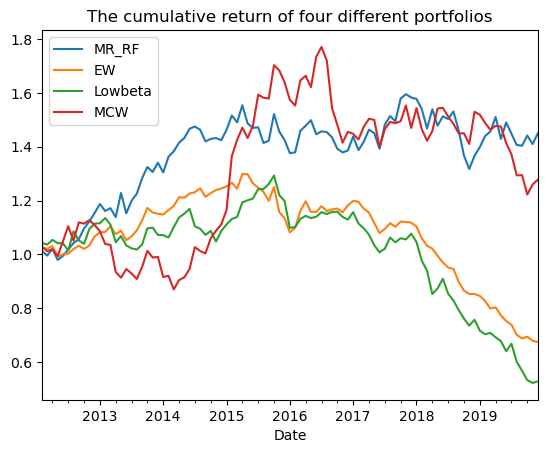

In [191]:
(df_portfolio.iloc[:,0:4]+1).cumprod().plot(title = "The cumulative return of four different portfolios")
plt.show()

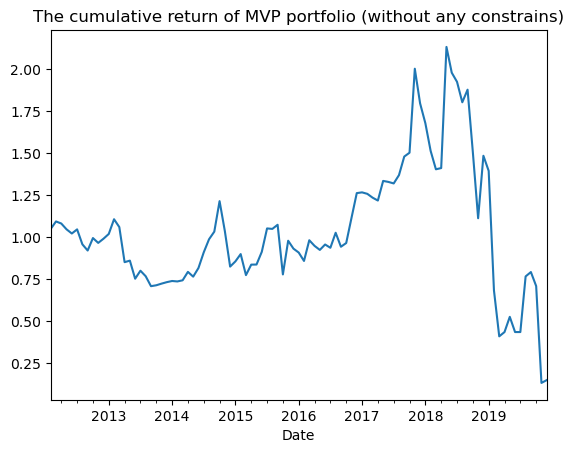

In [187]:
(df_portfolio.iloc[:,4]+1).cumprod().plot(title = "The cumulative return of MVP portfolio (without any constrains)")
plt.show()

In [188]:
df_portfolio.mean()

MR_RF      0.004406
EW        -0.003855
Lowbeta   -0.006117
MCW        0.003511
MVP        0.000783
dtype: float64

In [189]:
df_portfolio.std()

MR_RF      0.031443
EW         0.023586
Lowbeta    0.033721
MCW        0.043570
MVP        0.176591
dtype: float64

The reason why MVP has so large standard deviation is because we did not add any constrain to its weights, thus its long and short weights can be unrealistic large

#### 4.2 With long-only constrains

In [ ]:
from scipy.optimize import minimize

In [225]:
returns = df_SR

In [226]:
# the objective function is to minimize the portfolio risk
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(returns.cov()).dot(weights.T)
 
# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        {"type": "ineq", "fun": lambda x: np.sum(returns.mean()*x)-0.003}) 
 
 
# Every stock can get any weight from 0 to 1
bounds = tuple((0,1) for x in range(returns.shape[1])) 
 
# Initialize the weights with an even split
# In our case each stock will have 10% at the beginning
guess = [1./returns.shape[1] for x in range(returns.shape[1])]
 
 
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
optimized_results

     fun: nan
     jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan